## Assignment 8 - Analysis of Telecom Customer Churn using Spark

In [2]:
spark.stop()

In [3]:
sc.stop()

In [4]:
from pyspark import SparkConf, SparkContext
# setMaster() - set spark context manager which is local[cpu_cores]
config = SparkConf().setMaster("local[4]").setAppName("Assignment")
sc = SparkContext(conf=config)

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Assignment").getOrCreate()

In [6]:
sc

<SparkContext master=local[4] appName=Assignment>

In [7]:
spark

In [8]:
customer_df = spark.read.csv("file:///home/hadoop/Downloads/Telco_Customer_Churn.csv",header=True,inferSchema=True)

In [9]:
customer_df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [10]:
customer_df.createOrReplaceTempView("CustomerChurn")

In [11]:
from pyspark.sql.functions import *

Write Spark SQL queries to show following analysis with Visualization.

a) Analyze how customer retention varies based on how long the customer has stayed with the company (tenure).

In [12]:
result_a =spark.sql(f"""
SELECT
    tenure,
    COUNT(*) AS Total_Customers,
    SUM(CASE WHEN churn='No' THEN 1 ELSE 0 END) AS retained_customers,
    SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END) AS churned_customers,
    (SUM(CASE WHEN churn='No' THEN 1 ELSE 0 END)/COUNT(*))*100 AS Retention_Rate
FROM CustomerChurn
GROUP BY tenure
ORDER BY tenure
""")
result_a.show()

+------+---------------+------------------+-----------------+------------------+
|tenure|Total_Customers|retained_customers|churned_customers|    Retention_Rate|
+------+---------------+------------------+-----------------+------------------+
|     0|             11|                11|                0|             100.0|
|     1|            613|               233|              380| 38.00978792822186|
|     2|            238|               115|              123|48.319327731092436|
|     3|            200|               106|               94|              53.0|
|     4|            176|                93|               83| 52.84090909090909|
|     5|            133|                69|               64|  51.8796992481203|
|     6|            110|                70|               40| 63.63636363636363|
|     7|            131|                80|               51| 61.06870229007634|
|     8|            123|                81|               42| 65.85365853658537|
|     9|            119|    

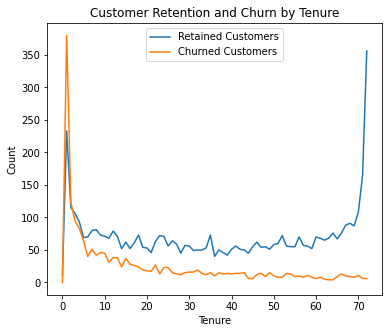

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = result_a.toPandas()
plt.figure(figsize=(6, 5))
sns.lineplot(data=df, x="tenure", y="retained_customers", label="Retained Customers")
sns.lineplot(data=df, x="tenure", y="churned_customers", label="Churned Customers")
plt.ylabel("Count")
plt.xlabel("Tenure")
plt.title("Customer Retention and Churn by Tenure")
plt.legend()
plt.show()



#### INSIGHTS
    * Lower retention rate for New Customers
    * High retention rate for Long term Customers

b) Investigate the churn rate of customers who subscribe to streaming services like StreamingTV and
StreamingMovies.

In [23]:
result_b = spark.sql(f"""
SELECT StreamingTV, StreamingMovies,
(SUM(CASE WHEN churn="Yes" THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS churn_rate,
(SUM(CASE WHEN churn='No' THEN 1 ELSE 0 END)/COUNT(*))*100 AS Retention_Rate
FROM CustomerChurn 
where StreamingTV = 'Yes' and StreamingMovies = 'Yes'
group by StreamingTV, StreamingMovies
ORDER BY churn_rate desc
""")
result_b.show()

+-----------+---------------+-----------------+-----------------+
|StreamingTV|StreamingMovies|       churn_rate|   Retention_Rate|
+-----------+---------------+-----------------+-----------------+
|        Yes|            Yes|29.43298969072165|70.56701030927836|
+-----------+---------------+-----------------+-----------------+



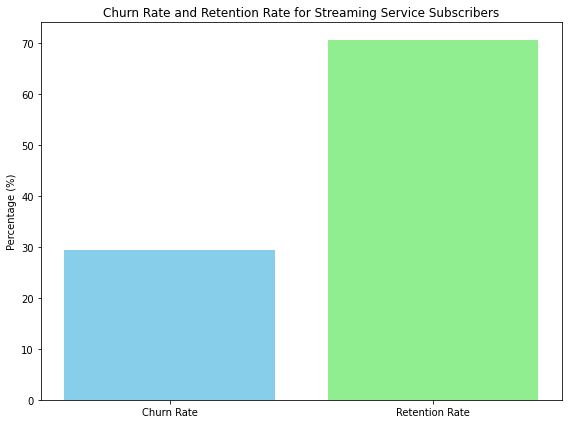

In [28]:
import matplotlib.pyplot as plt


churn_rate = result_b.select('churn_rate').first()[0]  
retention_rate = result_b.select('Retention_Rate').first()[0]  


categories = ['Churn Rate', 'Retention Rate']
values = [churn_rate, retention_rate]


plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen'])


plt.ylabel('Percentage (%)')
plt.title('Churn Rate and Retention Rate for Streaming Service Subscribers')

plt.tight_layout()
plt.show()


#### INSIGHTS
    * Higher churn rate for customers who does not subscribe to streaming services like StreamingTV and StreamingMovies

c) Write Spark SQL to group customers by their tenure (e.g., 0-12 months, 13-24 months, etc.) and analyze churn
rates in these tenure groups.

In [14]:
spark.sql(f"""
SELECT
    CASE
        WHEN tenure <= 12 THEN "0-12"
        WHEN tenure <= 24 THEN "13-24" 
        WHEN tenure <= 36 THEN "25-36"
        WHEN tenure <= 48 THEN "37-48"
        WHEN tenure <= 60 THEN "49-60"
        ELSE "61-72"
    END AS Tenure_Grp,
    COUNT(*) AS Total_Customers,
    SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END) AS churned_customers,
    (SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS Churn_Rate
FROM CustomerChurn
GROUP BY Tenure_Grp
ORDER BY Churn_Rate DESC
""").show()

+----------+---------------+-----------------+------------------+
|Tenure_Grp|Total_Customers|churned_customers|        Churn_Rate|
+----------+---------------+-----------------+------------------+
|      0-12|           2186|             1037|47.438243366880144|
|     13-24|           1024|              294|        28.7109375|
|     25-36|            832|              180|21.634615384615387|
|     37-48|            762|              145|19.028871391076116|
|     49-60|            832|              120|14.423076923076922|
|     61-72|           1407|               93| 6.609808102345416|
+----------+---------------+-----------------+------------------+



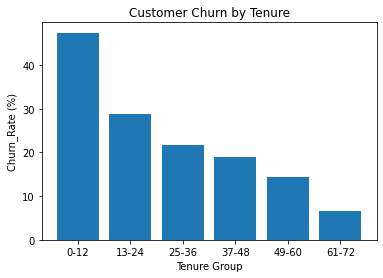

In [35]:
result_c = spark.sql(f"""
SELECT
    CASE
        WHEN tenure <= 12 THEN "0-12"
        WHEN tenure <= 24 THEN "13-24" 
        WHEN tenure <= 36 THEN "25-36"
        WHEN tenure <= 48 THEN "37-48"
        WHEN tenure <= 60 THEN "49-60"
        ELSE "61-72"
    END AS Tenure_Grp,
    COUNT(*) AS Total_Customers,
    SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END) AS churned_customers,
    (SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS Churn_Rate
FROM CustomerChurn
GROUP BY Tenure_Grp
ORDER BY Churn_Rate DESC
""").toPandas()

plt.bar(result_c['Tenure_Grp'],result_c['Churn_Rate'])
plt.xlabel("Tenure Group")
plt.ylabel("Churn_Rate (%)")
plt.title('Customer Churn by Tenure')
plt.show()

#### INSIGHTS
* 0-12 months Tenure group has higher Churn rate 
* 61-72 months Tenure group has lower churn rate

d) Analyze the impact of contract types and payment methods on churn rates.

In [15]:
result_d = spark.sql(f"""
SELECT Contract, PaymentMethod,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
GROUP BY Contract, PaymentMethod
ORDER BY churn_rate DESC
""").toPandas()

result_d

,Contract,PaymentMethod,churn_rate
0,Month-to-month,Electronic check,53.729730
1,Month-to-month,Bank transfer (automatic),34.125637
2,Month-to-month,Credit card (automatic),32.780847
3,Month-to-month,Mailed check,31.578947
4,One year,Electronic check,18.443804
5,One year,Credit card (automatic),10.301508
6,One year,Bank transfer (automatic),9.718670
7,Two year,Electronic check,7.738095
8,One year,Mailed check,6.824926
9,Two year,Bank transfer (automatic),3.368794


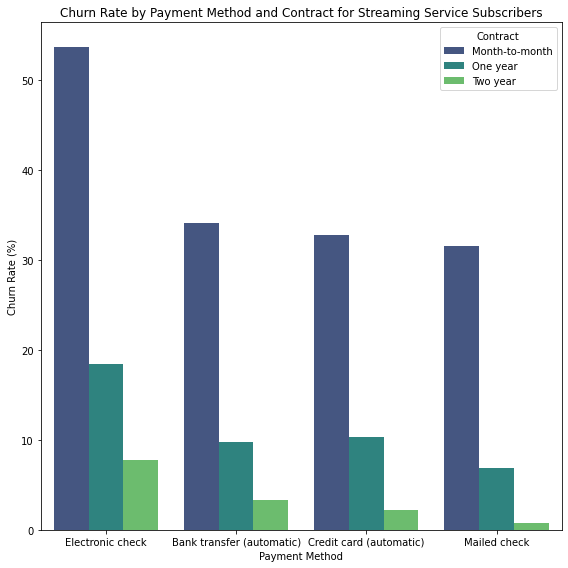

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
sns.barplot(data=result_d, x='PaymentMethod', y='churn_rate', hue='Contract', palette='viridis')

plt.xlabel('Payment Method')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Payment Method and Contract for Streaming Service Subscribers')
plt.tight_layout()
plt.show()


e) Explore the distribution of monthly charges for customers based on their type of internet service.

In [12]:
spark.sql(f"""
select InternetService, 
avg(MonthlyCharges) as Avg_Monthly_Charges
from CustomerChurn
group by InternetService
order by Avg_Monthly_Charges desc
""").show()

+---------------+-------------------+
|InternetService|Avg_Monthly_Charges|
+---------------+-------------------+
|    Fiber optic|  91.50012919896615|
|            DSL|  58.10216852540261|
|             No| 21.079193971166454|
+---------------+-------------------+



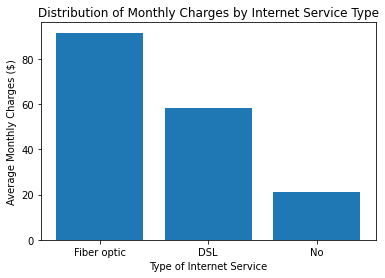

In [13]:
result_e = spark.sql(f"""
select InternetService, 
avg(MonthlyCharges) as Avg_Monthly_Charges
from CustomerChurn
group by InternetService
order by Avg_Monthly_Charges desc
""").toPandas()


plt.bar(result_e['InternetService'],result_e['Avg_Monthly_Charges'])
plt.title('Distribution of Monthly Charges by Internet Service Type')
plt.xlabel('Type of Internet Service')
plt.ylabel('Average Monthly Charges ($)')
plt.show()

f) Identify the top 10 customers who have contributed the most revenue to the company, based on total charges.

In [32]:
spark.sql(f"""
select customerID,TotalCharges from CustomerChurn
order by TotalCharges desc 
limit 10
""").show()

+----------+------------+
|customerID|TotalCharges|
+----------+------------+
|9093-FPDLG|       999.9|
|4536-PLEQY|       999.8|
|5899-MQZZL|      999.45|
|6051-PTVNS|       998.1|
|8249-THVEC|      997.75|
|6328-ZPBGN|      997.65|
|7297-DVYGA|      996.95|
|6243-OZGFH|      996.85|
|0484-JPBRU|      996.45|
|2971-SGAFL|      995.35|
+----------+------------+



g) Calculate the churn rate segmented by gender and whether the customer is a senior citizen.

+------+-------------+------------------+
|gender|SeniorCitizen|        churn_rate|
+------+-------------+------------------+
|Female|            1| 42.25352112676056|
|  Male|            1| 41.11498257839721|
|Female|            0|23.938356164383563|
|  Male|            0|23.280778262328077|
+------+-------------+------------------+



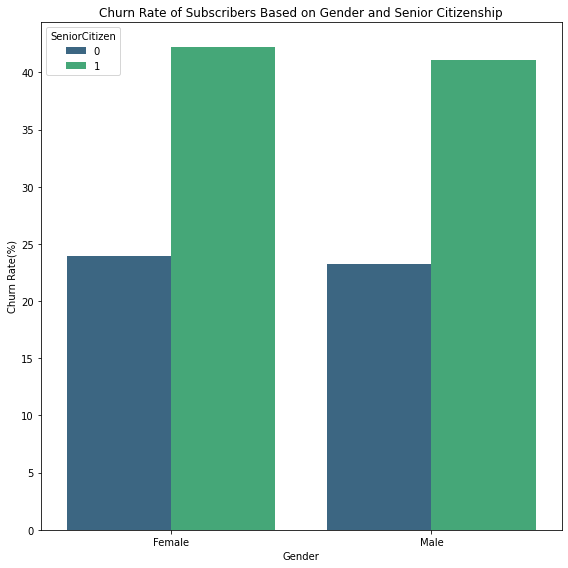

In [30]:
result_g = spark.sql(f"""
select gender,SeniorCitizen,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate 
from CustomerChurn
group by gender, SeniorCitizen
order by churn_rate desc
""")
result_g.show()

result_g = result_g.toPandas()

plt.figure(figsize=(8, 8))
sns.barplot(data=result_g, x='gender', y='churn_rate', hue = 'SeniorCitizen', palette='viridis')
plt.xlabel('Gender')
plt.ylabel('Churn Rate(%)')
plt.title('Churn Rate of Subscribers Based on Gender and Senior Citizenship')
plt.tight_layout()
plt.show()


h) Write query to calculate Correlation between dependents and churn. Explore whether having dependents affects
customer churn rates.

+----------+------------------+
|Dependents|        churn_rate|
+----------+------------------+
|        No|31.279140482465028|
|       Yes|15.450236966824646|
+----------+------------------+



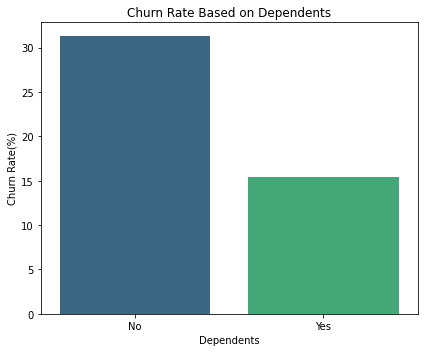

In [33]:
result_h = spark.sql(f"""
select Dependents,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate 
from CustomerChurn
group by Dependents
order by churn_rate desc
""")

result_h.show()

result_h = result_h.toPandas()
plt.figure(figsize=(6, 5))
sns.barplot(data=result_h, x='Dependents', y='churn_rate', palette='viridis')
plt.xlabel('Dependents')
plt.ylabel('Churn Rate(%)')
plt.title('Churn Rate Based on Dependents')
plt.tight_layout()
plt.show()

i) Predict potential churn rates by analyzing the relationship between monthly charges, contract types, and the
churn rate.

In [20]:
spark.sql(f"""
SELECT Contract,Avg(MonthlyCharges) as Avg_Monthly_Charges,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
GROUP BY Contract
ORDER BY churn_rate DESC
""").show()

+--------------+-------------------+------------------+
|      Contract|Avg_Monthly_Charges|        churn_rate|
+--------------+-------------------+------------------+
|Month-to-month|  66.39849032258037| 42.70967741935484|
|      One year|  65.04860828241674|11.269517990495586|
|      Two year|    60.770412979351| 2.831858407079646|
+--------------+-------------------+------------------+



#### INSIGHT
* As the contract time increases average monthly charge decreases and the churn rate also decreases.

j) Determine the churn rate for customers who have multiple services (Phone, Internet, and Streaming), which can
help understand whether bundling services leads to higher or lower churn. Calculate churn rate for customers
with multiple services.

In [37]:
spark.sql(f"""
SELECT PhoneService, InternetService, StreamingTV, StreamingMovies,
       (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS churn_rate
FROM CustomerChurn
WHERE PhoneService = 'Yes' 
  AND InternetService != 'No' 
  AND StreamingTV = 'Yes' 
  AND StreamingMovies = 'Yes'
GROUP BY PhoneService, InternetService, StreamingTV, StreamingMovies
ORDER BY churn_rate DESC
""").show()


+------------+---------------+-----------+---------------+-----------------+
|PhoneService|InternetService|StreamingTV|StreamingMovies|       churn_rate|
+------------+---------------+-----------+---------------+-----------------+
|         Yes|    Fiber optic|        Yes|            Yes|37.63358778625954|
|         Yes|            DSL|        Yes|            Yes| 8.13953488372093|
+------------+---------------+-----------+---------------+-----------------+



k) Churn Impact by device protection and online backup services. Write query to investigate whether having device
protection or online backup services affects churn rates.

In [29]:
spark.sql("""
SELECT OnlineBackup, DeviceProtection,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
group by OnlineBackup, DeviceProtection
ORDER BY churn_rate DESC
""").show()

+-------------------+-------------------+------------------+
|       OnlineBackup|   DeviceProtection|        churn_rate|
+-------------------+-------------------+------------------+
|                 No|                 No|45.917338709677416|
|                 No|                Yes|29.166666666666668|
|                Yes|                 No|27.002700270027002|
|                Yes|                Yes|  16.9195751138088|
|No internet service|No internet service| 7.404980340760157|
+-------------------+-------------------+------------------+



#### INSIGHT
* Churn rate is higher when there is no Online Backup and Device Protection
* Churn rate is lower when there is Online Backup and Device Protection

l) Explore churn rates among customers who do not have phone service and investigate if it influences customer
retention.

+------------+------------------+-----------------+
|PhoneService|        churn_rate|   retention_rate|
+------------+------------------+-----------------+
|          No|24.926686217008797| 75.0733137829912|
|         Yes| 26.70963684955196|73.29036315044804|
+------------+------------------+-----------------+



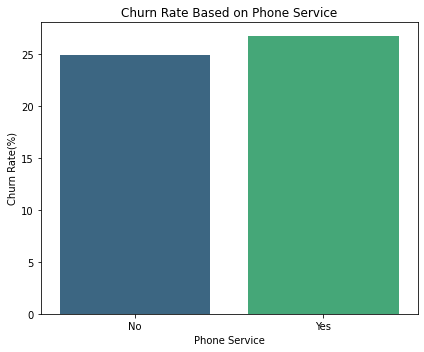

In [34]:
result_l =spark.sql(f"""
SELECT PhoneService,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate,
(SUM(CASE WHEN churn='No' THEN 1 ELSE 0 END)/COUNT(*))*100 AS retention_rate
from CustomerChurn
group by PhoneService
ORDER BY churn_rate 
""")

result_l.show()


result_l = result_l.toPandas()
plt.figure(figsize=(6, 5))
sns.barplot(data=result_l, x='PhoneService', y='churn_rate', palette='viridis')
plt.xlabel('Phone Service')
plt.ylabel('Churn Rate(%)')
plt.title('Churn Rate Based on Phone Service')
plt.tight_layout()
plt.show()

#### INSIGHTS
* Retention rate is higher when there is no Phoneservice.

m) Understand the relationship between payment methods and contract types on customer churn. This query will
help you discover which combinations are most prone to churn.

+--------------+--------------------+------------------+
|      Contract|       PaymentMethod|        churn_rate|
+--------------+--------------------+------------------+
|Month-to-month|    Electronic check|53.729729729729726|
|Month-to-month|Bank transfer (au...|34.125636672325975|
|Month-to-month|Credit card (auto...| 32.78084714548803|
|Month-to-month|        Mailed check| 31.57894736842105|
|      One year|    Electronic check|18.443804034582133|
|      One year|Credit card (auto...|10.301507537688442|
|      One year|Bank transfer (au...| 9.718670076726342|
|      Two year|    Electronic check| 7.738095238095238|
|      One year|        Mailed check| 6.824925816023739|
|      Two year|Bank transfer (au...| 3.368794326241135|
|      Two year|Credit card (auto...|2.2375215146299485|
|      Two year|        Mailed check|0.7853403141361256|
+--------------+--------------------+------------------+



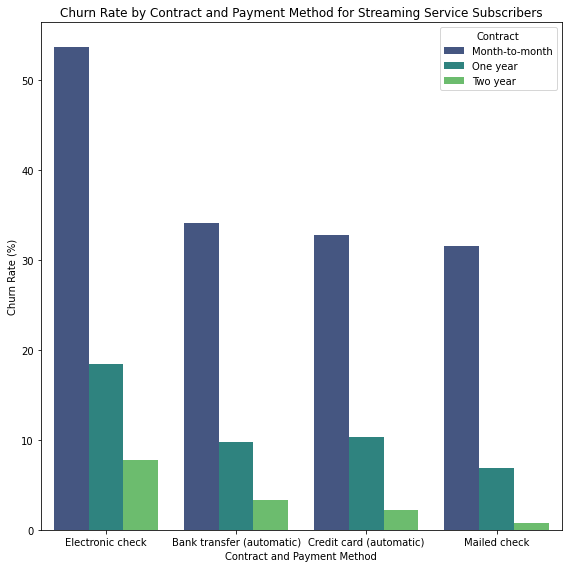

In [35]:
result_m = spark.sql("""
SELECT Contract, PaymentMethod,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
GROUP BY Contract, PaymentMethod
ORDER BY churn_rate DESC
""")

result_m.show()


result_m = result_m.toPandas()
plt.figure(figsize=(8, 8))
sns.barplot(data=result_m, x='PaymentMethod', y='churn_rate', hue = 'Contract', palette='viridis')
plt.xlabel('Contract and Payment Method')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Contract and Payment Method for Streaming Service Subscribers')
plt.tight_layout()
plt.show()

#### INSIGHT
* Month-to-Month and Electronic check combination have highest churn rate.

n) Analyze how customer churn is affected by senior citizen status and whether the customer has dependents.

+-------------+----------+------------------+
|SeniorCitizen|Dependents|        churn_rate|
+-------------+----------+------------------+
|            1|        No| 43.19695528068506|
|            0|        No|28.052550231839255|
|            1|       Yes|24.175824175824175|
|            0|       Yes|15.056958890539871|
+-------------+----------+------------------+



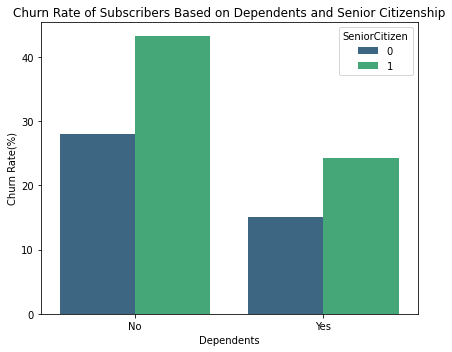

In [37]:
result_n = spark.sql(f"""
SELECT SeniorCitizen, Dependents,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
GROUP BY SeniorCitizen, Dependents
ORDER BY churn_rate DESC
""")
result_n.show()

result_n = result_n.toPandas()
plt.figure(figsize=(6, 5))
sns.barplot(data=result_n, x='Dependents', y='churn_rate', hue = 'SeniorCitizen', palette='viridis')
plt.xlabel('Dependents')
plt.ylabel('Churn Rate(%)')
plt.title('Churn Rate of Subscribers Based on Dependents and Senior Citizenship')
plt.tight_layout()
plt.show()

#### INSIGHT
* Senior citizens having no dependents have higher churn rate.

o) Explore whether subscribing to streaming services like Streaming TV and Streaming Movies influences the churn
rate.

In [41]:
spark.sql(f"""
SELECT StreamingTV, StreamingMovies,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
GROUP BY StreamingTV, StreamingMovies
ORDER BY churn_rate DESC
""").show()

+-------------------+-------------------+------------------+
|        StreamingTV|    StreamingMovies|        churn_rate|
+-------------------+-------------------+------------------+
|                 No|                 No|  34.4400396432111|
|                Yes|                 No|31.681877444589308|
|                 No|                Yes|31.186868686868685|
|                Yes|                Yes| 29.43298969072165|
|No internet service|No internet service| 7.404980340760157|
+-------------------+-------------------+------------------+



#### INSIGHT
* Churn rate is higher when there is no subscription to Streaming Services.

p) Understand how tenure and MonthlyCharges differ between churned and non-churned customers. This can
provide insights into the behavior of long-term customers.

In [34]:
spark.sql(f"""
SELECT churn,avg(tenure) as Avg_tenure, Avg(MonthlyCharges) as Avg_MonthlyCharges
FROM CustomerChurn
GROUP BY churn

""").show()

+-----+------------------+------------------+
|churn|        Avg_tenure|Avg_MonthlyCharges|
+-----+------------------+------------------+
|   No| 37.56996521066873|  61.2651236953999|
|  Yes|17.979133226324237|  74.4413322632423|
+-----+------------------+------------------+



#### INSIGHT

Long term customers have high average monthly charge and less churn rate.


q) Compare monthly charges and churn rates between newer customers and long-time customers.

In [47]:
spark.sql(f"""
SELECT
    CASE
        WHEN tenure <= 12 THEN "New Customers"
        ELSE "Long term Customers"
    END AS Tenure_Grp,Avg(MonthlyCharges) Avg_Monthly_Charge,
    (SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS Churn_Rate
FROM CustomerChurn
GROUP BY Tenure_Grp
ORDER BY Churn_Rate DESC
""").show()

+-------------------+------------------+------------------+
|         Tenure_Grp|Avg_Monthly_Charge|        Churn_Rate|
+-------------------+------------------+------------------+
|      New Customers| 56.09778133577306|47.438243366880144|
|Long term Customers| 68.66107679637616|17.129915585752524|
+-------------------+------------------+------------------+



r) What is the correlation between senior citizen status and churn rate?

+-------------+------------------+
|SeniorCitizen|        churn_rate|
+-------------+------------------+
|            1| 41.68126094570928|
|            0|23.606168446026096|
+-------------+------------------+



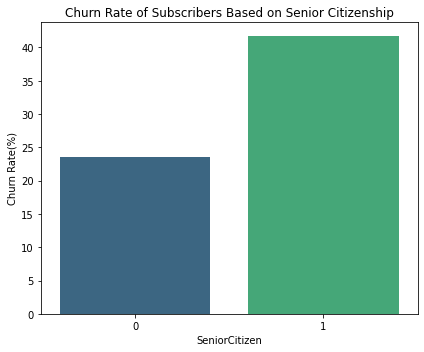

In [41]:
result_r = spark.sql(f"""
select SeniorCitizen,
(SUM(CASE WHEN churn='Yes' THEN 1 ELSE 0 END)/COUNT(*))*100 AS churn_rate
from CustomerChurn
group by SeniorCitizen
""")

result_r.show()


result_r = result_r.toPandas()
plt.figure(figsize=(6, 5))
sns.barplot(data=result_r, x='SeniorCitizen', y='churn_rate', palette='viridis')
plt.xlabel('SeniorCitizen')
plt.ylabel('Churn Rate(%)')
plt.title('Churn Rate of Subscribers Based on Senior Citizenship')
plt.tight_layout()
plt.show()

s) Partition customers based on whether they are senior citizens and divide them into 5 groups based on tenure.
[Use NTILE.]

In [14]:
spark.sql(f"""
select customerID,tenure,SeniorCitizen, 
NTILE(5) OVER(PARTITION BY SeniorCitizen ORDER BY tenure) as group from CustomerChurn
""").show(100)

+----------+------+-------------+-----+
|customerID|tenure|SeniorCitizen|group|
+----------+------+-------------+-----+
|8779-QRDMV|     1|            1|    1|
|3413-BMNZE|     1|            1|    1|
|2424-WVHPL|     1|            1|    1|
|0390-DCFDQ|     1|            1|    1|
|9514-JDSKI|     1|            1|    1|
|0021-IKXGC|     1|            1|    1|
|5564-NEMQO|     1|            1|    1|
|5192-EBGOV|     1|            1|    1|
|6513-EECDB|     1|            1|    1|
|7206-GZCDC|     1|            1|    1|
|1768-ZAIFU|     1|            1|    1|
|6567-HOOPW|     1|            1|    1|
|5240-IJOQT|     1|            1|    1|
|0661-XEYAN|     1|            1|    1|
|3068-OMWZA|     1|            1|    1|
|8580-AECUZ|     1|            1|    1|
|5047-LHVLY|     1|            1|    1|
|8375-DKEBR|     1|            1|    1|
|8080-DDEMJ|     1|            1|    1|
|6702-OHFWR|     1|            1|    1|
|4193-ORFCL|     1|            1|    1|
|9497-QCMMS|     1|            1|    1|


t) Use PERCENT_RANK to identify the top 5% of customers by MonthlyCharges.

In [15]:
spark.sql(f"""
select * from
(select CustomerID,Monthlycharges, PERCENT_RANK() OVER(ORDER BY MonthlyCharges DESC) as percent_rank
from CustomerChurn) as _
where percent_rank <= 0.05
""").show(truncate=False)

+----------+--------------+---------------------+
|CustomerID|Monthlycharges|percent_rank         |
+----------+--------------+---------------------+
|7569-NMZYQ|118.75        |0.0                  |
|8984-HPEMB|118.65        |1.4200511218403862E-4|
|5989-AXPUC|118.6         |2.8401022436807724E-4|
|5734-EJKXG|118.6         |2.8401022436807724E-4|
|8199-ZLLSA|118.35        |5.680204487361545E-4 |
|9924-JPRMC|118.2         |7.100255609201931E-4 |
|2889-FPWRM|117.8         |8.520306731042318E-4 |
|3810-DVDQQ|117.6         |9.940357852882703E-4 |
|9739-JLPQJ|117.5         |0.001136040897472309 |
|2302-ANTDP|117.45        |0.0012780460096563477|
|6904-JLBGY|117.35        |0.0014200511218403862|
|4282-MSACW|117.2         |0.0015620562340244249|
|6650-BWFRT|117.15        |0.0017040613462084636|
|9788-HNGUT|116.95        |0.001846066458392502 |
|1488-PBLJN|116.85        |0.0019880715705765406|
|0017-IUDMW|116.8         |0.0021300766827605793|
|8628-MFKAX|116.75        |0.002272081794944618 |


u) Find customers who fall within the top 5% of the distribution based on monthly charges. Compare total charges
with the next customer in the same internet service type, based on monthly charges.

In [16]:
result_u = spark.sql(f"""
SELECT customerID,MonthlyCharges, InternetService, 
       TotalCharges, 
       next_total_charges, 
       (TotalCharges - next_total_charges) AS charge_difference,
       PERCENT_RANK() OVER (PARTITION BY InternetService ORDER BY MonthlyCharges DESC) * 100 AS percentage
FROM (
    SELECT customerID, InternetService, MonthlyCharges, TotalCharges,
           LEAD(TotalCharges) OVER (PARTITION BY InternetService ORDER BY MonthlyCharges DESC) AS next_total_charges,
           PERCENT_RANK() OVER (PARTITION BY InternetService ORDER BY MonthlyCharges DESC) AS rank
    FROM CustomerChurn
) subquery
WHERE rank <= 0.05
""")

result_u.show()



+----------+--------------+---------------+------------+------------------+-------------------+------------------+
|customerID|MonthlyCharges|InternetService|TotalCharges|next_total_charges|  charge_difference|        percentage|
+----------+--------------+---------------+------------+------------------+-------------------+------------------+
|7569-NMZYQ|        118.75|    Fiber optic|     8672.45|            8477.6| 194.85000000000036|               0.0|
|8984-HPEMB|        118.65|    Fiber optic|      8477.6|           7990.05|  487.5500000000002|0.6451612903225806|
|5989-AXPUC|         118.6|    Fiber optic|     7990.05|            7365.7|  624.3500000000004|1.2903225806451613|
|5734-EJKXG|         118.6|    Fiber optic|      7365.7|           7804.15| -438.4499999999998|1.2903225806451613|
|8199-ZLLSA|        118.35|    Fiber optic|     7804.15|           8547.15|             -743.0|2.5806451612903225|
|9924-JPRMC|         118.2|    Fiber optic|     8547.15|            8684.8|-137.

v) Find the top 5 customers with the highest MonthlyCharges within each Contract type.

In [31]:
spark.sql(f"""
SELECT customerID, Contract, MonthlyCharges
FROM (
    SELECT customerID, Contract, MonthlyCharges,
           RANK() OVER (PARTITION BY Contract ORDER BY MonthlyCharges DESC) AS rank
    FROM CustomerChurn
) ranked_customers
WHERE rank <= 5
""").show(100)

+----------+--------------+--------------+
|customerID|      Contract|MonthlyCharges|
+----------+--------------+--------------+
|2302-ANTDP|Month-to-month|        117.45|
|8016-NCFVO|Month-to-month|         116.5|
|9659-QEQSY|Month-to-month|        115.65|
|4361-BKAXE|Month-to-month|         114.5|
|6710-HSJRD|Month-to-month|         114.1|
|5734-EJKXG|      One year|         118.6|
|8199-ZLLSA|      One year|        118.35|
|2889-FPWRM|      One year|         117.8|
|4282-MSACW|      One year|         117.2|
|3680-CTHUH|      One year|         116.6|
|7569-NMZYQ|      Two year|        118.75|
|8984-HPEMB|      Two year|        118.65|
|5989-AXPUC|      Two year|         118.6|
|9924-JPRMC|      Two year|         118.2|
|3810-DVDQQ|      Two year|         117.6|
+----------+--------------+--------------+



w) Calculate the churn rate in each Contract type and rank the contracts by churn rate

In [49]:
spark.sql("""
select *, dense_rank() over(order by churn_rate desc)as rank from
(select Contract,
sum(case when churn = 'Yes' then 1 else 0 end)/count(*) * 100 as churn_rate
from CustomerChurn group by Contract) as _
""").show()

+--------------+------------------+----+
|      Contract|        churn_rate|rank|
+--------------+------------------+----+
|Month-to-month| 42.70967741935484|   1|
|      One year|11.269517990495586|   2|
|      Two year| 2.831858407079646|   3|
+--------------+------------------+----+



x) Perform an in-depth analysis of customers using window functions to understand customer rankings,
distribution, and trends in charges and tenure.

In [32]:
spark.sql(f"""
SELECT 
    customerID,
    MonthlyCharges,
    tenure,
    Contract,
    RANK() OVER (ORDER BY MonthlyCharges DESC) AS rank,
    AVG(MonthlyCharges) OVER (PARTITION BY Contract) AS avg_monthly_charge_by_contract,
    COUNT(customerID) OVER (ORDER BY MonthlyCharges) AS customer_count,
    NTILE(10) OVER (ORDER BY MonthlyCharges) AS decile,
    AVG(MonthlyCharges) OVER (PARTITION BY tenure) AS avg_monthly_charge_by_tenure,
    AVG(TotalCharges) OVER (PARTITION BY tenure) AS avg_total_charge_by_tenure,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) OVER (PARTITION BY tenure) * 1.0 / COUNT(*) OVER (PARTITION BY tenure) AS churn_rate
FROM CustomerChurn
ORDER BY Contract, MonthlyCharges DESC
""").show()


+----------+--------------+------+--------------+----+------------------------------+--------------+------+----------------------------+--------------------------+------------------+
|customerID|MonthlyCharges|tenure|      Contract|rank|avg_monthly_charge_by_contract|customer_count|decile|avg_monthly_charge_by_tenure|avg_total_charge_by_tenure|        churn_rate|
+----------+--------------+------+--------------+----+------------------------------+--------------+------+----------------------------+--------------------------+------------------+
|2302-ANTDP|        117.45|    48|Month-to-month|  10|             66.39849032258057|          7034|    10|           64.33593750000001|        3083.3578124999995|0.1406250000000000|
|8016-NCFVO|         116.5|    55|Month-to-month|  21|             66.39849032258057|          7023|    10|           67.82968750000002|             3732.02578125|0.1406250000000000|
|9659-QEQSY|        115.65|    45|Month-to-month|  43|             66.39849032258057|

In [30]:
spark.sql(f"""
select * from CustomerChurn
""")

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: string, Churn: string]